<a href="https://colab.research.google.com/github/olivala/ChicagoCrime/blob/main/CDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal: using chicago crime data from 2017 and 2018 predict the crime trends for 2019.

Data Sources: https://data.cityofchicago.org/Public-Safety/Crimes-2017/d62x-nvdr/about_data https://data.cityofchicago.org/Public-Safety/Crimes-2018/3i3m-jwuy/about_data

In [1]:
!pip install sodapy

In [23]:
#load packages
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
#api data
#https://dev.socrata.com/foundry/data.cityofchicago.org/d62x-nvdr
client = Socrata("data.cityofchicago.org", None)
results = client.get("d62x-nvdr", limit=300000)
results_df = pd.DataFrame.from_records(results)

In [6]:
working_df2017=results_df.copy(deep='TRUE')
working_df2017.head()

,:@computed_region_d9mm_jgwp,:@computed_region_43wa_7qmu,date,location,district,y_coordinate,block,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,...,domestic,longitude,:@computed_region_bdys_3d7i,beat,:@computed_region_6mkv_f3dw,arrest,primary_type,:@computed_region_vrxf_vc4k,id,:@computed_region_d3ds_rm58
0,1,20,2017-12-31T23:58:00.000,"{'latitude': '41.965693651', 'human_address': ...",017,1930694,046XX N ST LOUIS AVE,20,41.965693651,2,...,False,-87.715726125,24,1723,21849,False,BURGLARY,14,11192233,9
1,5,34,2017-12-31T23:50:00.000,"{'latitude': '41.926558908', 'human_address': ...",019,1916610,024XX N LAKE SHORE DR NB,16,41.926558908,51,...,False,-87.631294073,101,1935,4449,False,BATTERY,68,11196379,178
2,14,11,2017-12-31T23:48:00.000,"{'latitude': '41.895750913', 'human_address': ...",018,1905401,001XX E SUPERIOR ST,6,41.895750913,22,...,False,-87.623495923,158,1833,21182,False,THEFT,37,11192540,71
3,10,43,2017-12-31T23:45:00.000,"{'latitude': '41.683369303', 'human_address': ...",005,1828012,115XX S STATE ST,19,41.683369303,30,...,True,-87.622829524,255,0522,21861,False,BATTERY,50,11192254,219
4,15,26,2017-12-31T23:45:00.000,"{'latitude': '41.856426716', 'human_address': ...",012,1891037,019XX S CANAL ST,40,41.856426716,8,...,True,-87.638892854,126,1235,21194,False,CRIMINAL DAMAGE,33,11192239,158


In [7]:
#API for 2018
#https://dev.socrata.com/foundry/data.cityofchicago.org/3i3m-jwuy
client = Socrata("data.cityofchicago.org", None)
results = client.get("3i3m-jwuy", limit=300000)
results_df2 = pd.DataFrame.from_records(results)

In [9]:
working_df2018=results_df2.copy(deep='TRUE')
working_df2018.head()

,:@computed_region_d9mm_jgwp,:@computed_region_43wa_7qmu,date,location,district,y_coordinate,block,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,...,longitude,:@computed_region_bdys_3d7i,beat,:@computed_region_6mkv_f3dw,arrest,primary_type,:@computed_region_vrxf_vc4k,id,:@computed_region_d3ds_rm58,location_description
0,17,32,2018-12-31T23:59:00.000,"{'latitude': '41.763181359', 'human_address': ...",007,1857018,013XX W 72ND ST,23,41.763181359,17,...,-87.657709477,408,0734,22257,False,DECEPTIVE PRACTICE,65,11561837,216,NaN
1,9,42,2018-12-31T23:59:00.000,"{'latitude': '41.689078832', 'human_address': ...",022,1829936,112XX S SACRAMENTO AVE,33,41.689078832,33,...,-87.696064026,256,2211,4447,False,CRIMINAL DAMAGE,73,11556487,254,STREET
2,NaN,NaN,2018-12-31T23:59:00.000,NaN,004,NaN,100XX S OGLESBY AVE,NaN,NaN,NaN,...,NaN,NaN,0431,NaN,False,OFFENSE INVOLVING CHILDREN,NaN,13247802,NaN,RESIDENCE
3,20,13,2018-12-31T23:57:00.000,"{'latitude': '41.740520866', 'human_address': ...",006,1848783,084XX S SANGAMON ST,59,41.740520866,18,...,-87.647390719,530,0613,21554,False,CRIMINAL DAMAGE,70,11552699,233,APARTMENT
4,15,26,2018-12-31T23:56:00.000,"{'latitude': '41.857068095', 'human_address': ...",012,1891230,018XX S ALLPORT ST,43,41.857068095,8,...,-87.657625201,365,1233,14920,True,BATTERY,33,11552724,150,OTHER


In [11]:
crime = pd.concat([working_df2017, working_df2018], ignore_index=True)
crime.head()

,:@computed_region_d9mm_jgwp,:@computed_region_43wa_7qmu,date,location,district,y_coordinate,block,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,...,domestic,longitude,:@computed_region_bdys_3d7i,beat,:@computed_region_6mkv_f3dw,arrest,primary_type,:@computed_region_vrxf_vc4k,id,:@computed_region_d3ds_rm58
0,1,20,2017-12-31T23:58:00.000,"{'latitude': '41.965693651', 'human_address': ...",017,1930694,046XX N ST LOUIS AVE,20,41.965693651,2,...,False,-87.715726125,24,1723,21849,False,BURGLARY,14,11192233,9
1,5,34,2017-12-31T23:50:00.000,"{'latitude': '41.926558908', 'human_address': ...",019,1916610,024XX N LAKE SHORE DR NB,16,41.926558908,51,...,False,-87.631294073,101,1935,4449,False,BATTERY,68,11196379,178
2,14,11,2017-12-31T23:48:00.000,"{'latitude': '41.895750913', 'human_address': ...",018,1905401,001XX E SUPERIOR ST,6,41.895750913,22,...,False,-87.623495923,158,1833,21182,False,THEFT,37,11192540,71
3,10,43,2017-12-31T23:45:00.000,"{'latitude': '41.683369303', 'human_address': ...",005,1828012,115XX S STATE ST,19,41.683369303,30,...,True,-87.622829524,255,0522,21861,False,BATTERY,50,11192254,219
4,15,26,2017-12-31T23:45:00.000,"{'latitude': '41.856426716', 'human_address': ...",012,1891037,019XX S CANAL ST,40,41.856426716,8,...,True,-87.638892854,126,1235,21194,False,CRIMINAL DAMAGE,33,11192239,158


In [12]:
#check size
crime.shape

(538202, 30)

In [13]:
for column in range(crime.shape[1]):
  print(crime[crime.columns[column]].count())

527109
527060
538202
528520
538201
528520
538202
527060
528520
526827
538202
535765
538202
538202
538202
528520
538197
538202
538202
538202
538202
528520
527274
538202
528520
538202
538202
527054
538202
527111


In [14]:
#seperate date col
#convert to pandas
crime['date']=pd.to_datetime(crime['date'])
#year col
crime['year']=crime['date'].dt.year
#month col
crime['month']=crime['date'].dt.month
#day col
crime['day']=crime['date'].dt.day
#hour col
crime['hour']=crime['date'].dt.hour

crime.head()

,:@computed_region_d9mm_jgwp,:@computed_region_43wa_7qmu,date,location,district,y_coordinate,block,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,...,beat,:@computed_region_6mkv_f3dw,arrest,primary_type,:@computed_region_vrxf_vc4k,id,:@computed_region_d3ds_rm58,month,day,hour
0,1,20,2017-12-31 23:58:00,"{'latitude': '41.965693651', 'human_address': ...",017,1930694,046XX N ST LOUIS AVE,20,41.965693651,2,...,1723,21849,False,BURGLARY,14,11192233,9,12,31,23
1,5,34,2017-12-31 23:50:00,"{'latitude': '41.926558908', 'human_address': ...",019,1916610,024XX N LAKE SHORE DR NB,16,41.926558908,51,...,1935,4449,False,BATTERY,68,11196379,178,12,31,23
2,14,11,2017-12-31 23:48:00,"{'latitude': '41.895750913', 'human_address': ...",018,1905401,001XX E SUPERIOR ST,6,41.895750913,22,...,1833,21182,False,THEFT,37,11192540,71,12,31,23
3,10,43,2017-12-31 23:45:00,"{'latitude': '41.683369303', 'human_address': ...",005,1828012,115XX S STATE ST,19,41.683369303,30,...,0522,21861,False,BATTERY,50,11192254,219,12,31,23
4,15,26,2017-12-31 23:45:00,"{'latitude': '41.856426716', 'human_address': ...",012,1891037,019XX S CANAL ST,40,41.856426716,8,...,1235,21194,False,CRIMINAL DAMAGE,33,11192239,158,12,31,23


In [16]:
#remove cols
crime.drop(columns=['id','case_number','date','block','iucr','description','location_description','x_coordinate','y_coordinate','location'],inplace=True)

In [17]:
crime.dropna(inplace=True)

In [18]:
monthly_crimes = crime.groupby(['year', 'month']).size().reset_index(name='CrimeCount')

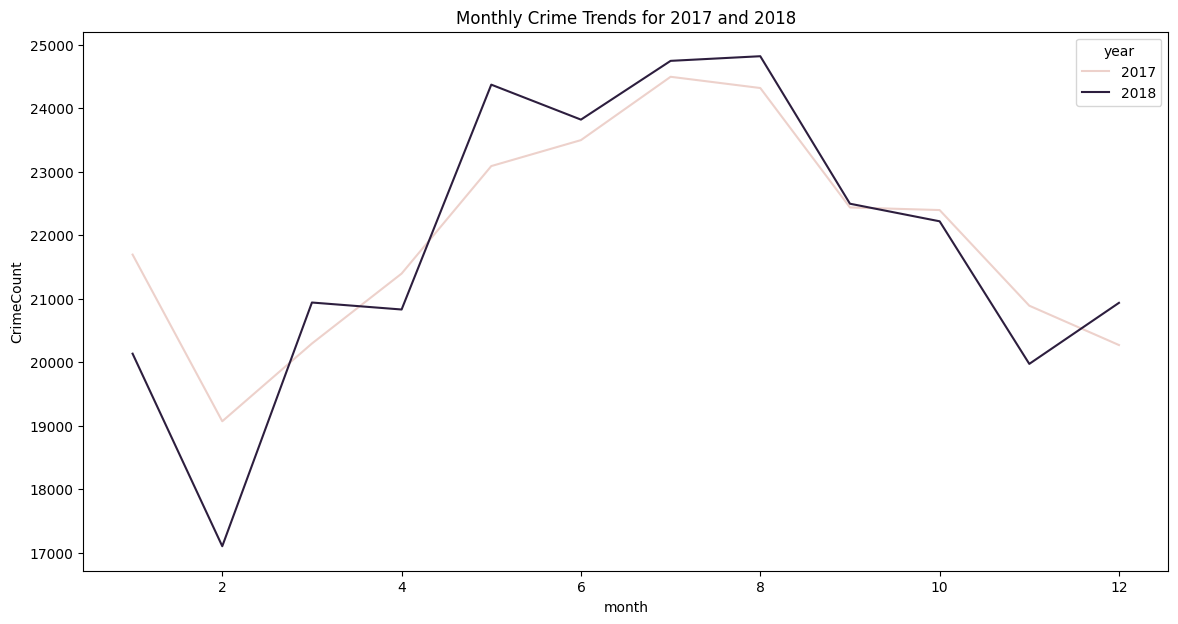

In [20]:
#line graph
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_crimes, x='month', y='CrimeCount', hue='year')
plt.title('Monthly Crime Trends for 2017 and 2018')
plt.show()


In [25]:
X = monthly_crimes[['year', 'month']]
y = monthly_crimes['CrimeCount']
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)
#train model
mod = RandomForestRegressor(n_estimators=100, random_state=48)
mod.fit(X_train, y_train)
#predict
y_pred = mod.predict(X_test)


In [26]:
#mse
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 198530.0697399998
Mean Absolute Error: 339.78600000000006


Predictions will be off by approximatly 339.79 crimes per month

In [27]:
months_2019 = pd.DataFrame({'year': [2019]*12, 'month': list(range(1, 13))})
predictions_2019 = mod.predict(months_2019)
pred_2019_df = pd.DataFrame({'year': 2019, 'month': list(range(1, 13)), 'PredictedCrimeCount': predictions_2019})
print(pred_2019_df)

    year  month  PredictedCrimeCount
0   2019      1             20105.07
1   2019      2             18327.10
2   2019      3             20499.12
3   2019      4             20789.80
4   2019      5             23766.40
5   2019      6             23982.87
6   2019      7             24686.94
7   2019      8             24717.60
8   2019      9             23104.98
9   2019     10             22270.83
10  2019     11             20752.99
11  2019     12             20790.23


In [29]:
#load in 2019 data
#https://dev.socrata.com/foundry/data.cityofchicago.org/w98m-zvie
client = Socrata("data.cityofchicago.org", None)
results = client.get("w98m-zvie", limit=300000)
results_df3 = pd.DataFrame.from_records(results)

In [30]:
working_df2019=results_df3.copy(deep='TRUE')
working_df2019.head()

,:@computed_region_d9mm_jgwp,:@computed_region_43wa_7qmu,date,location,district,y_coordinate,block,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,...,domestic,longitude,:@computed_region_bdys_3d7i,beat,:@computed_region_6mkv_f3dw,arrest,primary_type,:@computed_region_vrxf_vc4k,id,:@computed_region_d3ds_rm58
0,17,32,2019-12-31T23:55:00.000,"{'latitude': '41.769150218', 'human_address': ...",007,1859260,0000X W 69TH ST,11,41.769150218,31,...,False,-87.627136786,513,0731,21559,True,WEAPONS VIOLATION,67,11938228,201
1,17,2,2019-12-31T23:54:00.000,"{'latitude': '41.779173667', 'human_address': ...",007,1862855,063XX S MAY ST,11,41.779173667,19,...,False,-87.653277703,436,0724,21559,False,BATTERY,66,11940078,203
2,NaN,NaN,2019-12-31T23:50:00.000,NaN,012,NaN,004XX N Ashland ave,NaN,NaN,NaN,...,False,NaN,NaN,1215,NaN,False,THEFT,NaN,11938857,NaN
3,25,7,2019-12-31T23:48:00.000,"{'latitude': '41.874623951', 'human_address': ...",015,1897452,004XX S CICERO AVE,32,41.874623951,36,...,False,-87.745052647,69,1533,22216,True,WEAPONS VIOLATION,26,11938240,137
4,16,23,2019-12-31T23:46:00.000,"{'latitude': '41.877268465', 'human_address': ...",011,1898480,034XX W JACKSON BLVD,30,41.877268465,11,...,False,-87.711536692,783,1133,21572,False,WEAPONS VIOLATION,28,11937967,86


In [31]:
working_df2019['date'] = pd.to_datetime(working_df2019['date'])

In [32]:
working_df2019['year'] = working_df2019['date'].dt.year
working_df2019['month'] = working_df2019['date'].dt.month

In [33]:
actual_monthly_crimes_2019 = working_df2019.groupby(['year', 'month']).size().reset_index(name='ActualCrimeCount')
pred_2019_df = pd.DataFrame({'year': 2019, 'month': list(range(1, 13)), 'PredictedCrimeCount': predictions_2019})
comparison_df = pd.merge(pred_2019_df, actual_monthly_crimes_2019, on=['year', 'month'], how='left')


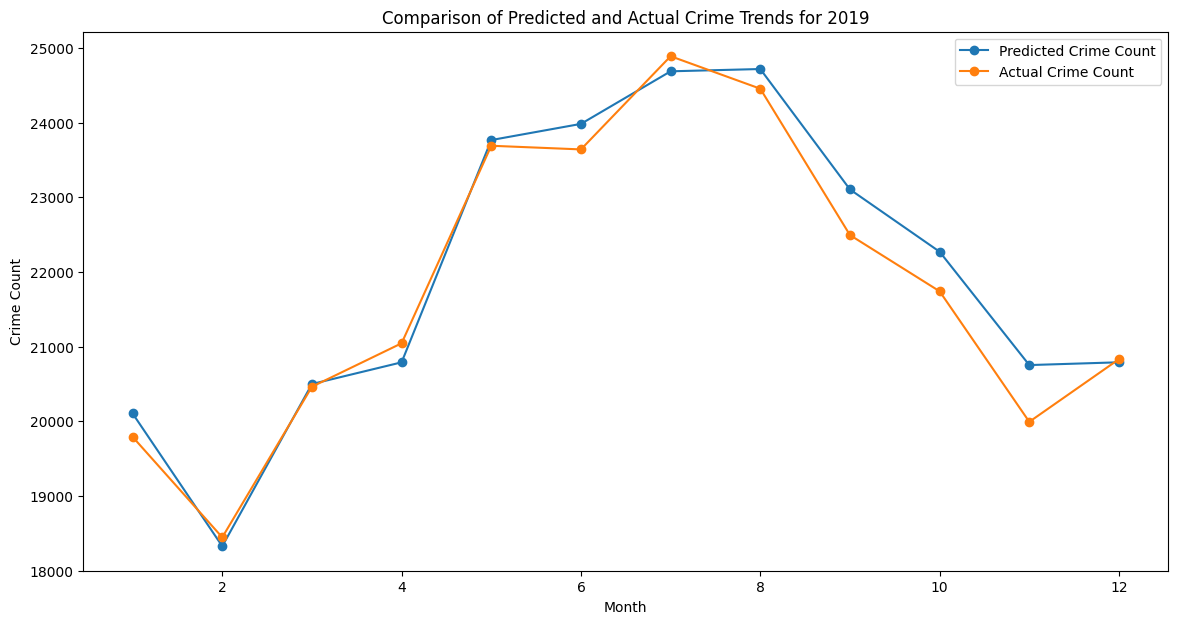

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['month'], comparison_df['PredictedCrimeCount'], label='Predicted Crime Count', marker='o')
plt.plot(comparison_df['month'], comparison_df['ActualCrimeCount'], label='Actual Crime Count', marker='o')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.title('Comparison of Predicted and Actual Crime Trends for 2019')
plt.legend()
plt.show()